# Dependencies

In [1]:
import pkg_resources
import sys
import subprocess

# List of required packages (use package names as recognized by pip)
required = {
    'geopandas',
    'osmnx',
    'contextily',
    'libpysal',
    'esda',
    'pointpats',
    'matplotlib',
    'seaborn',
    'scikit-learn'
}

# Get the set of installed packages
installed = {pkg.key for pkg in pkg_resources.working_set}

# Determine which packages are missing
missing = required - installed

if missing:
    print(f"Installing missing packages: {missing}")
    subprocess.check_call([sys.executable, "-m", "pip", "install", *missing])
else:
    print("All required packages are already installed.")

All required packages are already installed.


# Python imports

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
from shapely.geometry import Point
from libpysal.weights import Queen
from esda import Moran, Moran_Local
from sklearn.cluster import DBSCAN, KMeans
import os


# Data collection

In [4]:
data_path = "./data/NYPD_Complaint_Data_Historic.csv"
url = "https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD"

# columns to load
cols = ["CMPLNT_FR_DT", "LAW_CAT_CD", "BORO_NM", "ADDR_PCT_CD", "Latitude", "Longitude"]

# Check if the file exists locally
if os.path.exists(data_path):
    print("Loading data from local file...")
    crime_df = pd.read_csv(data_path, usecols=cols)
else:
    print("Downloading data from API...")
    crime_df = pd.read_csv(url, usecols=cols)
    # Save the fetched data to a local CSV file for future use
    crime_df.to_csv(data_path, index=False)

# Convert dates to datetime. Parse errors will set value to NaT
crime_df["CMPLNT_FR_DT"] = pd.to_datetime(crime_df["CMPLNT_FR_DT"], format="%m/%d/%Y", errors='coerce')

# Filter for year 2019
crime_df = crime_df[crime_df["CMPLNT_FR_DT"].dt.year == 2019]

# Drop records with missing or invalid coordinates
crime_df = crime_df.dropna(subset=["Latitude", "Longitude"])
crime_df = crime_df[crime_df["Latitude"] != 0]

print(f"Total records in 2019: {len(crime_df)}")
crime_df.head(3)


Loading data from local file...
Total records in 2019: 459296


,CMPLNT_FR_DT,ADDR_PCT_CD,LAW_CAT_CD,BORO_NM,Latitude,Longitude
73179,2019-09-30,106.0,FELONY,QUEENS,40.674100,-73.844419
2356244,2019-11-01,61.0,VIOLATION,BROOKLYN,40.585029,-73.933156
2416574,2019-12-14,47.0,FELONY,BRONX,40.887049,-73.867793


## Inspecting the data

Number of: FELONY 142217
Number of: VIOLATION 72399
Number of: MISDEMEANOR 244680


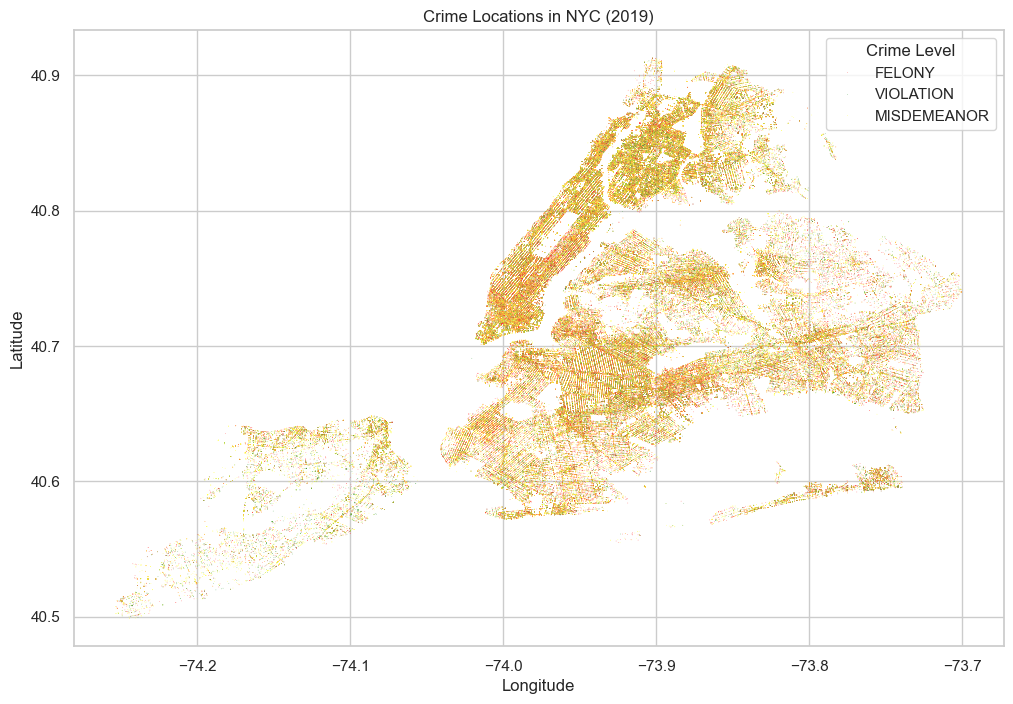

In [5]:
crimelevels = crime_df["LAW_CAT_CD"].unique()
for c in crimelevels:
    print(f"Number of: {c} {len(crime_df[crime_df['LAW_CAT_CD'] == c])}")
    
# Violations are green, misdemeanors are yellow, felonies are red
colors = {
    "VIOLATION": "green",
    "MISDEMEANOR": "yellow",
    "FELONY": "red"
}
# scatterplot of the three crime levels
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.scatterplot(data=crime_df, x="Longitude", y="Latitude", hue="LAW_CAT_CD", palette=colors, alpha=0.5, s=0.3)
plt.title("Crime Locations in NYC (2019)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Crime Level")
plt.show()
